In [29]:
!pip install featuretools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 16.0 MB/s eta 0:00:00


In [30]:
!pip install woodwork

In [306]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
import plotly.express as px
from woodwork.logical_types import Categorical, Double, Integer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from featuretools.primitives import TransformPrimitive
from woodwork.column_schema import ColumnSchema
# from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE



In [349]:
glass = pd.read_csv('/content/sample_data/glass.data', delimiter=',', header=None)
# glass = pd.read_csv('data/glass.data', delimiter=',', header=None)

glass.head()


,0,1,2,3,4,5,6,7,8,9,10
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [350]:
glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       214 non-null    int64  
 1   1       214 non-null    float64
 2   2       214 non-null    float64
 3   3       214 non-null    float64
 4   4       214 non-null    float64
 5   5       214 non-null    float64
 6   6       214 non-null    float64
 7   7       214 non-null    float64
 8   8       214 non-null    float64
 9   9       214 non-null    float64
 10  10      214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [351]:
name = pd.read_csv('/content/sample_data/name.csv', delimiter=':')
# name = pd.read_csv('dz_7/name.csv', delimiter=':')

n = name.iloc[:, 0].tolist()
n


['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

In [352]:
glass.columns =n
glass.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [353]:
glass.columns

Index(['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type'], dtype='object')

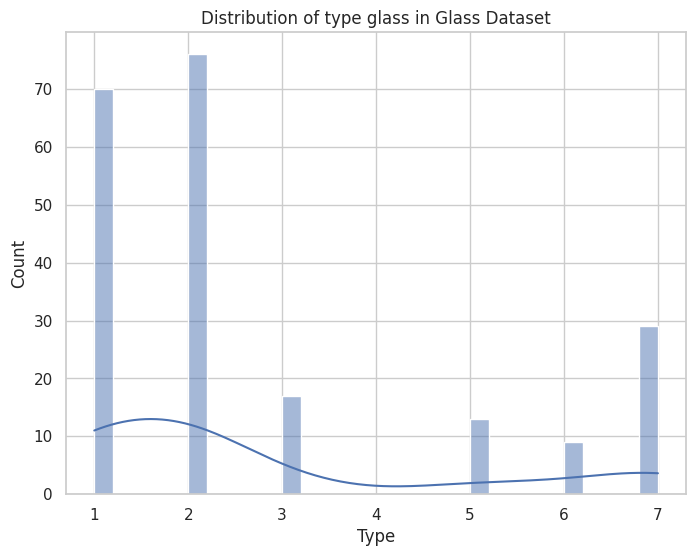

In [354]:
plt.figure(figsize=(8, 6))
sns.histplot(glass['Type'], bins=30, kde=True)
plt.title("Distribution of type glass in Glass Dataset")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()

бачимо несбалансований датасет бачимо перекос 1, 2, 7 типів скла

In [355]:
n[1:10]

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

In [356]:
numeric_features = n[1:10]

X_tsne = glass[numeric_features].values

In [357]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne_embedded = tsne.fit_transform(X_tsne)

In [358]:
fig = px.scatter_3d(
    x=X_tsne_embedded[:, 0],
    y=X_tsne_embedded[:, 1],
    z=X_tsne_embedded[:, 2],
    color=glass['Type'],
    title="Interactive T-SNE Visualization of Glass Data (Type, 3D)",
    labels={'x': 'T-SNE Component 1', 'y': 'T-SNE Component 2', 'z': 'T-SNE Component 3'},
    # color_continuous_scale='Viridis'
)
fig.update_layout(width=800, height=600)
fig.show()

TSNE показує що хоча наш датасет не є рівномірним ми бачимо досить чітко виділені групи данних

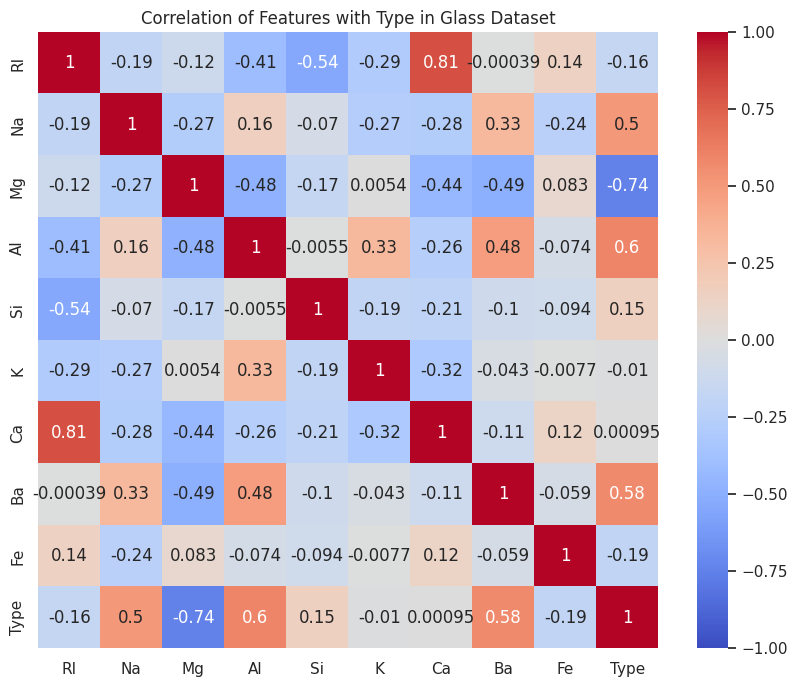

In [359]:
plt.figure(figsize=(10, 8))
correlation_matrix = glass[numeric_features + ['Type']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation of Features with Type in Glass Dataset")
plt.show()

сореляція дуже багато відхилень тож для подальшої роботи візьмемо весь датасет так як він не великий

побудуємо боксплоти для наших фіч

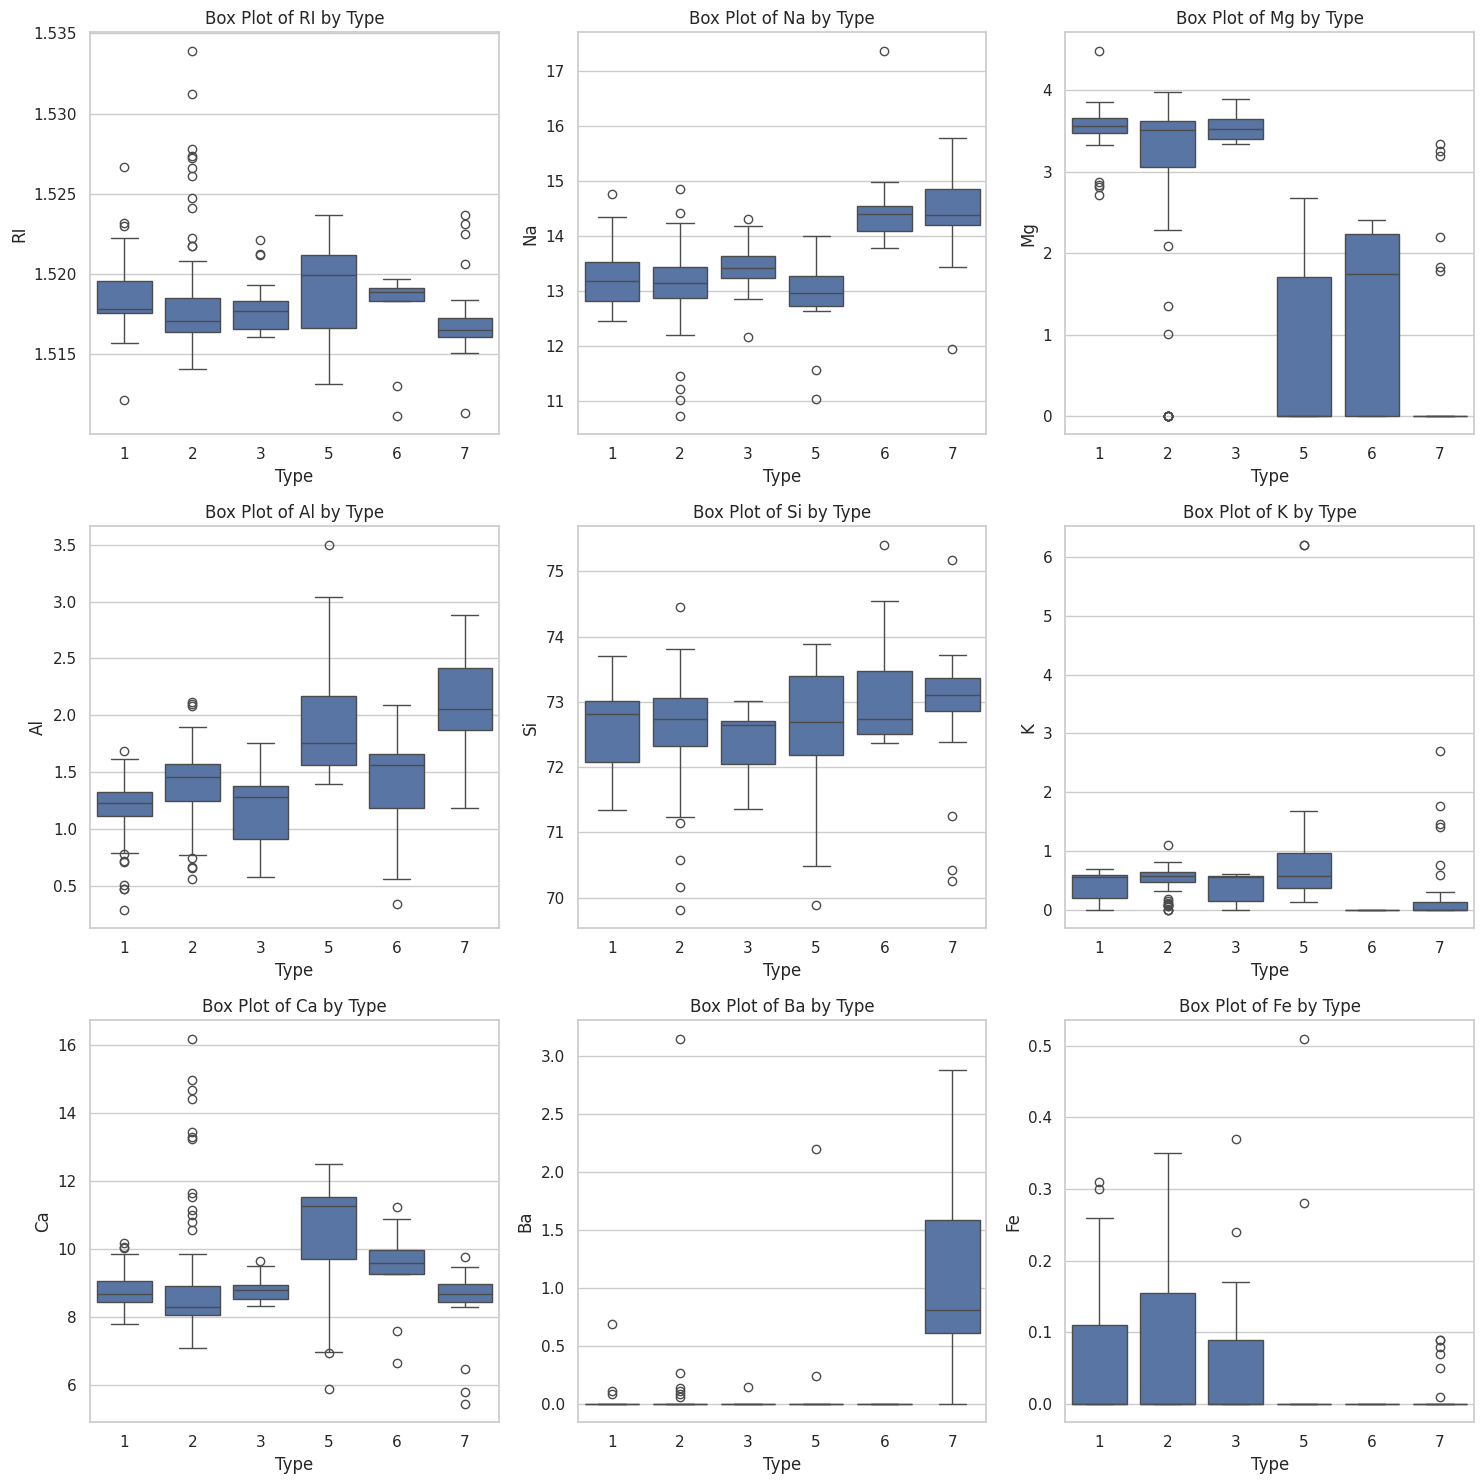

In [360]:

num_cols = 3
num_rows = math.ceil(len(numeric_features) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(numeric_features):
    sns.boxplot(x='Type', y=column, data=glass, ax=axes[i])
    axes[i].set_title(f"Box Plot of {column} by Type")
    axes[i].set_xlabel("Type")
    axes[i].set_ylabel(column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

графіки підтіерджують що датасет незбалансований  але деякі фічі в яких теж є дизбаланс і це цікаво босаме цей дисбаланс можливо допоможе нам відокремлювати класи

створемо еталонні моделі

In [443]:
X = glass.drop(columns=["Id","Type"]).values
y = glass["Type"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


RidgeClassifier

RidgeClassifier Precision: 0.543


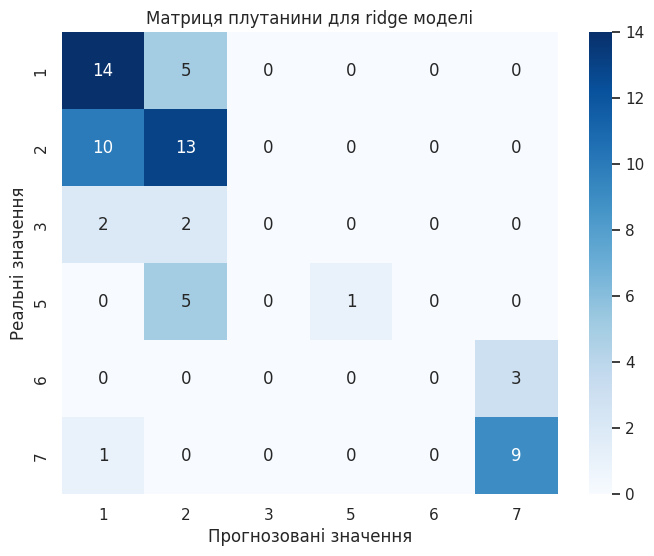


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.52      0.74      0.61        19
           2       0.52      0.57      0.54        23
           3       1.00      0.00      0.00         4
           5       1.00      0.17      0.29         6
           6       1.00      0.00      0.00         3
           7       0.75      0.90      0.82        10

    accuracy                           0.57        65
   macro avg       0.80      0.39      0.38        65
weighted avg       0.65      0.57      0.52        65


Точність моделі (Accuracy): 0.5692307692307692


In [362]:
ridge = RidgeClassifier()
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
precision_ridge = precision_score(y_test, y_pred_ridge, average='weighted', zero_division=0)
print(f"RidgeClassifier Precision: {precision_ridge:.3f}")


conf_matrix = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для ridge моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_ridge, zero_division=1))
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print(f"\nТочність моделі (Accuracy): {accuracy_ridge}")

KNN

KNN (k=5) Precision: 0.604


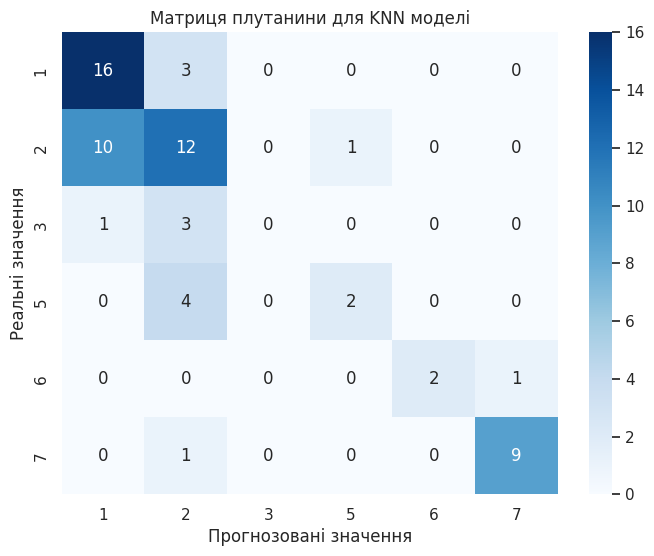


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.59      0.84      0.70        19
           2       0.52      0.52      0.52        23
           3       0.00      0.00      0.00         4
           5       0.67      0.33      0.44         6
           6       1.00      0.67      0.80         3
           7       0.90      0.90      0.90        10

    accuracy                           0.63        65
   macro avg       0.61      0.54      0.56        65
weighted avg       0.60      0.63      0.60        65


Точність моделі (Accuracy): 0.6307692307692307


In [363]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
print(f"KNN (k=5) Precision: {precision_knn:.3f}")


conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для KNN моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_knn, zero_division=0))
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nТочність моделі (Accuracy): {accuracy_knn}")

Logistic Regression

Logistic Regression Precision: 0.667


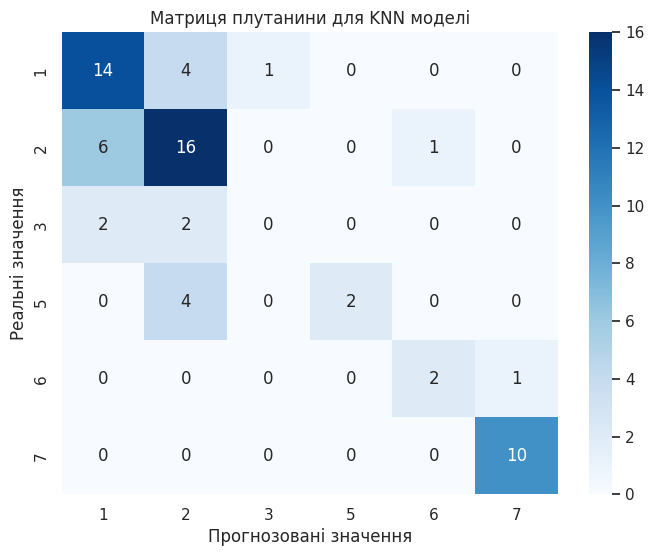


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.64      0.74      0.68        19
           2       0.62      0.70      0.65        23
           3       0.00      0.00      0.00         4
           5       1.00      0.33      0.50         6
           6       0.67      0.67      0.67         3
           7       0.91      1.00      0.95        10

    accuracy                           0.68        65
   macro avg       0.64      0.57      0.58        65
weighted avg       0.67      0.68      0.65        65


Точність моделі (Accuracy): 0.676923076923077


In [364]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
precision_logreg = precision_score(y_test, y_pred_logreg, average='weighted', zero_division=0)
print(f"Logistic Regression Precision: {precision_logreg:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для KNN моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"\nТочність моделі (Accuracy): {accuracy_logreg}")

в єталонних моделях Precision: 0.543 - 0.667 а (Accuracy): 0.676 - 0.569 для такого не сбалансованого датасету дуже непоганий покозчик але 3, 5 таргет взагалі не влучає

додамо данні за допомогою SMOTE, SVMSMOTE та порівняємо що краще

SMOTE

In [381]:
X = glass.drop(columns=['Id', 'Type'])
y = glass['Type']

In [382]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [325]:
print("Початковий розподіл класів:")
print(y.value_counts())

Початковий розподіл класів:
Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64


In [326]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [385]:
X_scaled = scaler.fit_transform(X)


In [386]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [387]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_series = pd.Series(y_resampled, name='Type')


In [388]:
glass_balanced_SMOTE = pd.concat([X_resampled_df, y_resampled_series], axis=1)

In [389]:
glass_balanced_SMOTE

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1
...,...,...,...,...,...,...,...,...,...,...
451,-0.945943,0.749727,-1.865511,2.353275,0.863367,-0.599522,0.187242,1.058032,-0.257043,7
452,-0.500808,1.813936,-1.865511,1.092426,0.557772,-0.763919,-0.384212,2.848559,-0.517748,7
453,-0.724518,-0.915534,-1.865511,0.493269,2.337117,1.926716,0.106372,0.252625,-0.548305,7
454,-0.425934,1.831948,-1.865511,0.839213,0.490213,-0.763919,-0.321339,2.878583,-0.586451,7


In [390]:
print("\nРозподіл класів після SMOTE:")
print(glass_balanced_SMOTE['Type'].value_counts())


Розподіл класів після SMOTE:
Type
1    76
2    76
3    76
5    76
6    76
7    76
Name: count, dtype: int64


In [391]:
glass_balanced_SMOTE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      456 non-null    float64
 1   Na      456 non-null    float64
 2   Mg      456 non-null    float64
 3   Al      456 non-null    float64
 4   Si      456 non-null    float64
 5   K       456 non-null    float64
 6   Ca      456 non-null    float64
 7   Ba      456 non-null    float64
 8   Fe      456 non-null    float64
 9   Type    456 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 35.8 KB


SVM-SMOTE

In [401]:

svm_smote = SVMSMOTE(sampling_strategy='auto', random_state=42)
X_resampled_SVM, y_resampled_SVM = svm_smote.fit_resample(X_scaled, y)


In [402]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [403]:
X_resampled_df_SVM = pd.DataFrame(X_resampled_SVM, columns=X.columns)
y_resampled_series_SVM = pd.Series(y_resampled_SVM, name='Type')

In [404]:
glass_balanced_SVMSMOTE = pd.concat([X_resampled_df_SVM, y_resampled_series_SVM], axis=1)


In [405]:
glass_balanced_SVMSMOTE

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1
...,...,...,...,...,...,...,...,...,...,...
382,-0.692118,0.826178,-1.865511,2.851220,1.089687,-0.691182,0.094609,0.364858,0.339372,7
383,0.072026,1.250329,-1.865511,0.634016,0.123002,1.897245,-2.096906,6.009149,-0.586451,7
384,-0.585604,0.885589,-1.865511,2.802901,1.229915,-0.702443,0.047424,0.263543,0.702840,7
385,-0.095400,1.209221,-1.865511,0.712959,0.198201,1.619438,-1.890122,5.702481,-0.586451,7


In [406]:
print("\nРозподіл класів після SMOTE:")
print(glass_balanced_SVMSMOTE['Type'].value_counts())


Розподіл класів після SMOTE:
Type
1    76
2    76
5    76
7    76
3    46
6    37
Name: count, dtype: int64


Подивимось на наші нові датасети

In [407]:
glass_balanced_SVMSMOTE.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1


In [408]:
glass_balanced_SMOTE.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1


додамо нових фіч за допомогою featuretools


In [420]:
glass_balanced_SMOTE['id'] = range(len(glass_balanced_SMOTE))


In [421]:
glass_balanced_SMOTE.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type', 'id'], dtype='object')

In [422]:
es = ft.EntitySet(id="glass_dataset_SMOTE")
es = es.add_dataframe(
    dataframe_name="glass_balanced_SMOTE",
    dataframe=glass_balanced_SMOTE,
    index="id",
    logical_types={
        'id': Integer,
        'RI': Double,
        'Na': Double,
        'Mg': Double,
        'Al': Double,
        'Si': Double,
        'K': Double,
        'Ca': Double,
        'Ba': Double,
        'Fe': Double,
        'Type': Integer,
    }
)
es

Entityset: glass_dataset_SMOTE
  DataFrames:
    glass_balanced_SMOTE [Rows: 456, Columns: 11]
  Relationships:
    No relationships

зробимо 2 нових примітива

In [423]:
class Square(TransformPrimitive):
    name = "square"
    input_types = [ColumnSchema(semantic_tags={"numeric"})]
    return_type = ColumnSchema(semantic_tags={"numeric"})

    def get_function(self):
        return lambda x: x ** 2

class Log(TransformPrimitive):
    name = "log"
    input_types = [ColumnSchema(semantic_tags={"numeric"})]
    return_type = ColumnSchema(semantic_tags={"numeric"})

    def get_function(self):
        return lambda x: np.log(x + 1)

In [424]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="glass_balanced_SMOTE",
    trans_primitives=[
        "divide_numeric",
        "add_numeric",
        "multiply_numeric",
        "subtract_numeric",
        "absolute",
        "percentile",
        Square,
        Log,
    ],
    max_depth=1,
    ignore_columns={"glass_balanced_SMOTE": ["Type"]}
)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



In [425]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 455
Columns: 225 entries, RI to RI - Si
dtypes: float64(225)
memory usage: 805.1 KB


In [426]:
feature_matrix_SMOTE_cleaned = feature_matrix.replace([np.inf, -np.inf], 0)
feature_matrix_SMOTE_cleaned = feature_matrix_SMOTE_cleaned.dropna(axis=1, how='any')


In [428]:
feature_matrix_SMOTE_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 0 to 455
Columns: 219 entries, RI to RI - Si
dtypes: float64(219)
memory usage: 783.8 KB


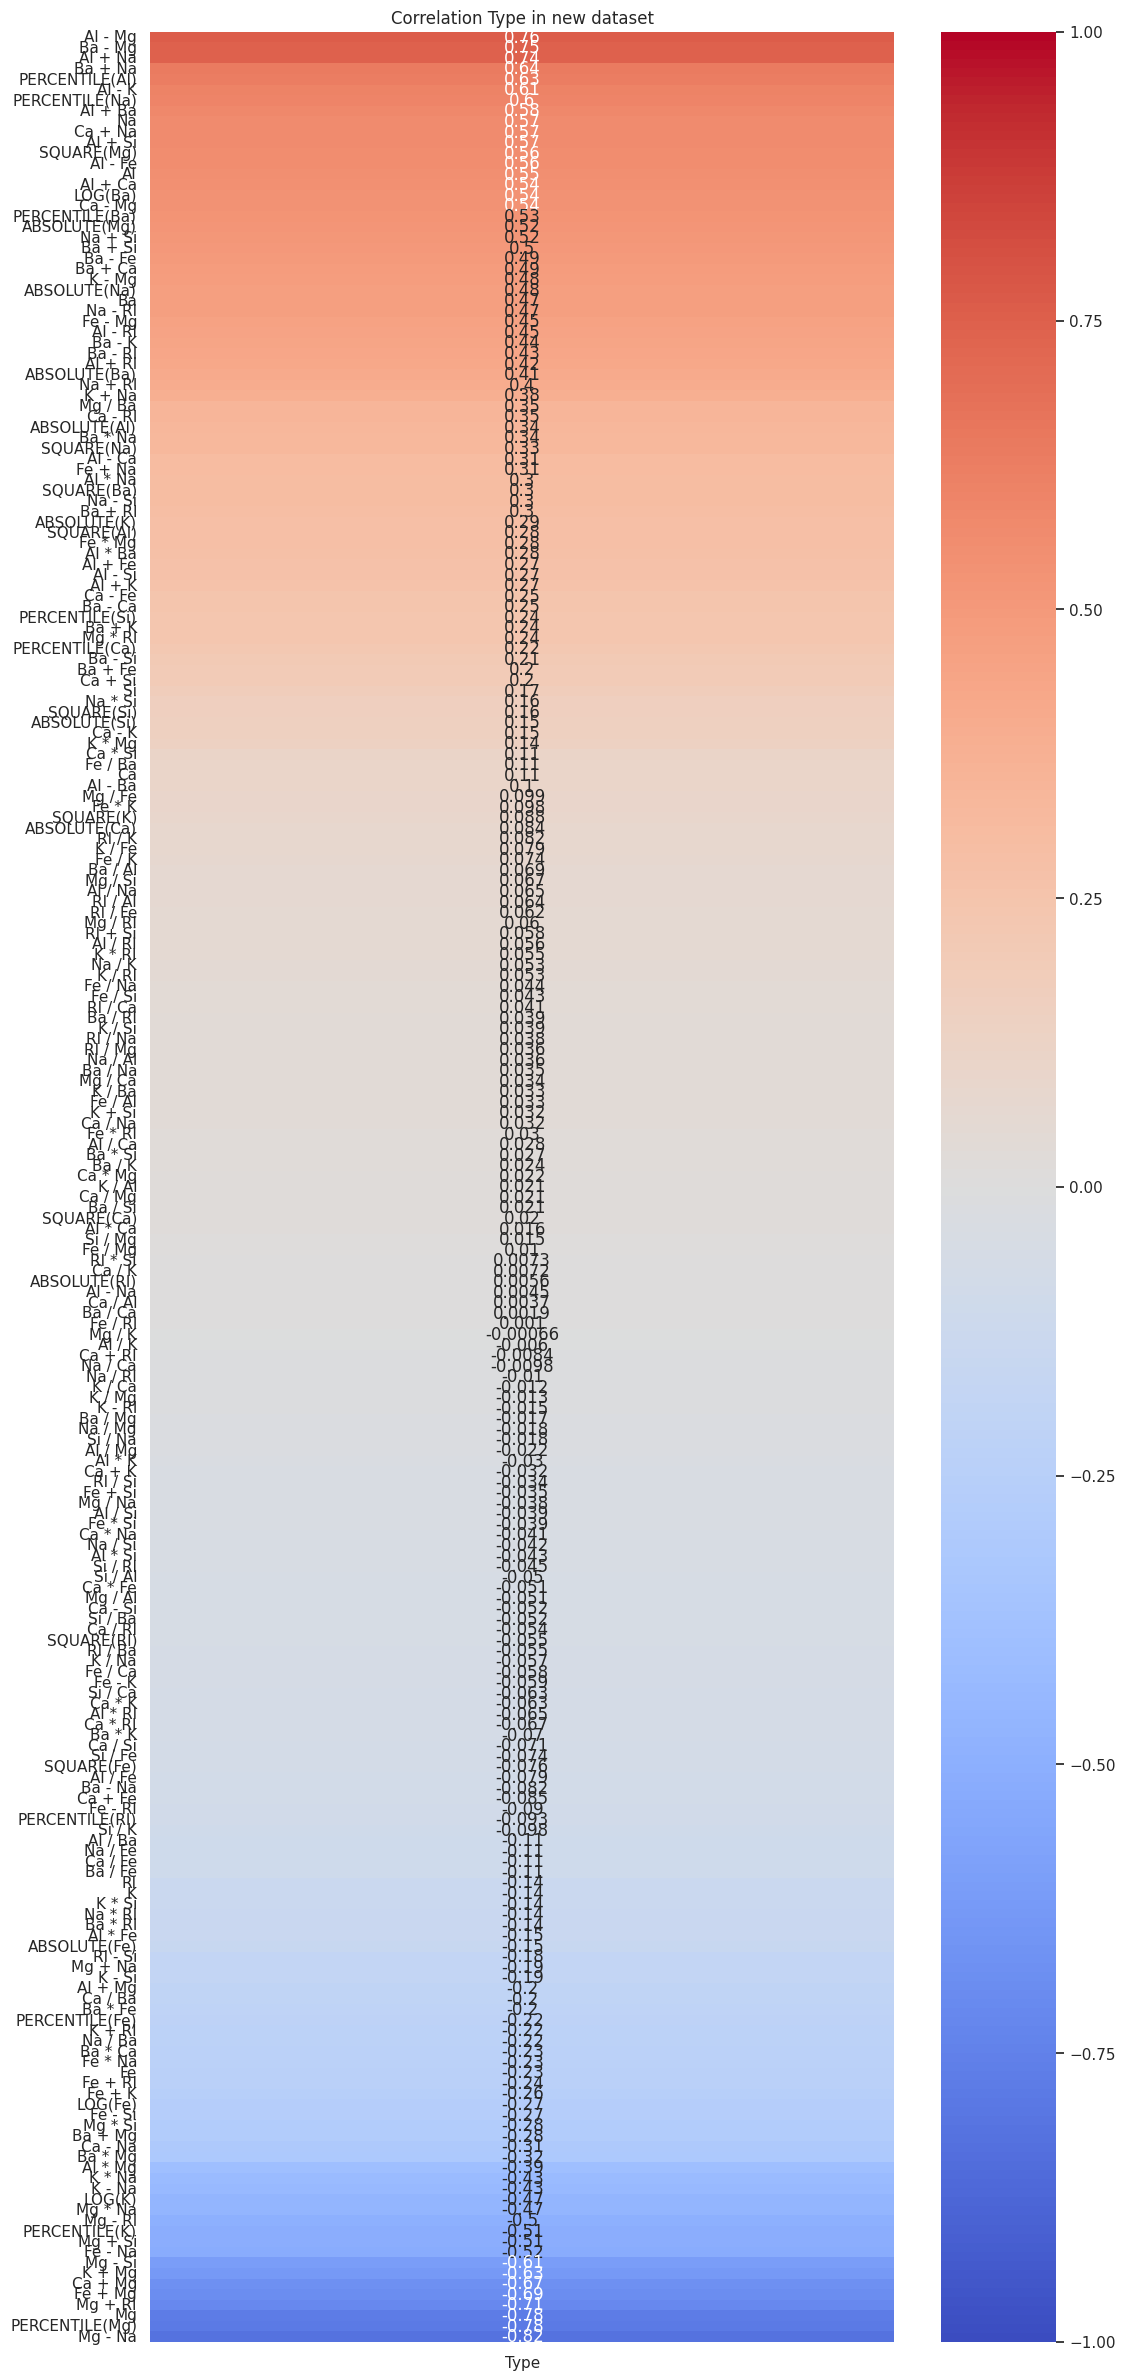

In [429]:
feature_matrix_SMOTE_cleaned['Type'] = glass_balanced_SMOTE['Type']
plt.figure(figsize=(12, 30))

correlation_new_features = feature_matrix_SMOTE_cleaned.corr()['Type'].drop('Type')
correlation_new_features_sort = correlation_new_features.sort_values(ascending=False)
sns.heatmap(
    correlation_new_features_sort.to_frame(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    xticklabels=['Type'],
    yticklabels=correlation_new_features_sort.index
)
plt.title("Correlation Type in new dataset")
plt.show()


наші створені фічі добре корелюють також бачемо що відсутні фічі повязані з таргетом так як моделі досить швидкі зменшувати кількість не будемо

In [409]:
glass_balanced_SVMSMOTE['id'] = range(len(glass_balanced_SVMSMOTE))


In [410]:
es = ft.EntitySet(id="glass_dataset_SVMSMOTE")
es = es.add_dataframe(
    dataframe_name="glass_balanced_SVMSMOTE",
    dataframe=glass_balanced_SVMSMOTE,
    index="id",
    logical_types={
        'id': Integer,
        'RI': Double,
        'Na': Double,
        'Mg': Double,
        'Al': Double,
        'Si': Double,
        'K': Double,
        'Ca': Double,
        'Ba': Double,
        'Fe': Double,
        'Type': Integer,
    }
)
es

Entityset: glass_dataset_SVMSMOTE
  DataFrames:
    glass_balanced_SVMSMOTE [Rows: 387, Columns: 11]
  Relationships:
    No relationships

In [411]:
feature_matrix_SVM, feature_defs_SVM = ft.dfs(
    entityset=es,
    target_dataframe_name="glass_balanced_SVMSMOTE",
    trans_primitives=[
        "divide_numeric",
        "add_numeric",
        "multiply_numeric",
        "subtract_numeric",
        "absolute",
        "percentile",
        Square,
        Log,
    ],
    max_depth=1,
    ignore_columns={"glass_balanced_SVMSMOTE": ["Type"]}
)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



In [412]:
feature_matrix_SVMSMOTE_cleaned = feature_matrix_SVM.replace([np.inf, -np.inf], 0)
feature_matrix_SVMSMOTE_cleaned = feature_matrix_SVMSMOTE_cleaned.dropna(axis=1, how='any')


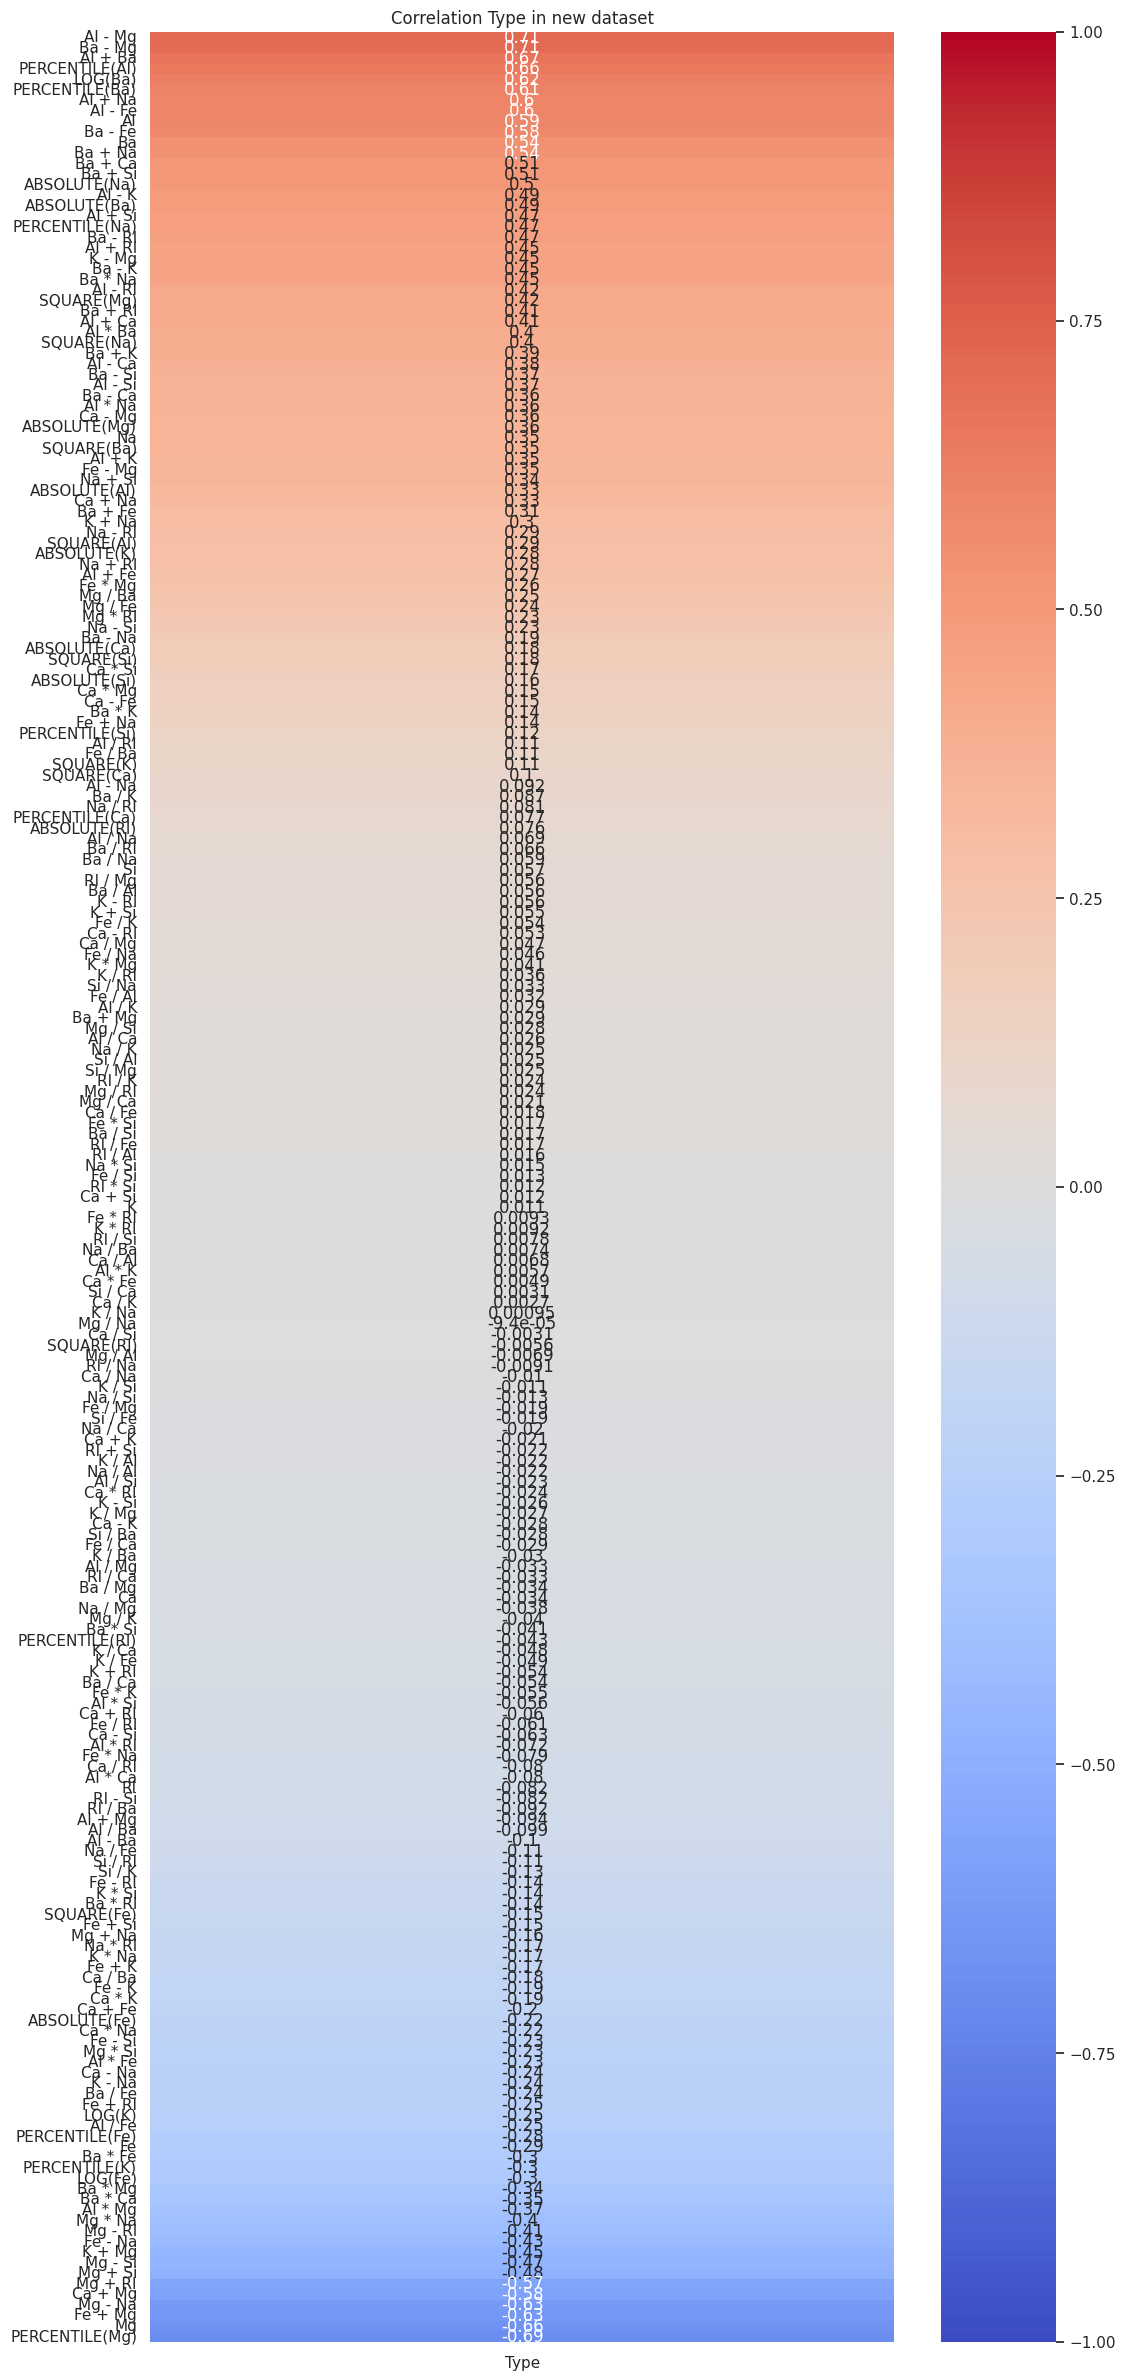

In [413]:
feature_matrix_SVMSMOTE_cleaned['Type'] = glass_balanced_SMOTE['Type']
plt.figure(figsize=(12, 30))

correlation_new_features = feature_matrix_SVMSMOTE_cleaned.corr()['Type'].drop('Type')
correlation_new_features_sort = correlation_new_features.sort_values(ascending=False)
sns.heatmap(
    correlation_new_features_sort.to_frame(),
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    xticklabels=['Type'],
    yticklabels=correlation_new_features_sort.index
)
plt.title("Correlation Type in new dataset")
plt.show()


SVMSMOTE показує такіж добрі результати але тут трохи менше зайшли в мінус

будуємо модели для SVMSMOTE

In [414]:
X_SS = feature_matrix_SVMSMOTE_cleaned.drop(columns=["Type"]).values
y_SS = feature_matrix_SVMSMOTE_cleaned["Type"].values
X_train, X_test, y_train, y_test = train_test_split(X_SS, y_SS, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled_SS = scaler.fit_transform(X_train)
X_test_scaled_SS = scaler.transform(X_test)

RidgeClassifier

RidgeClassifier Precision: 0.649


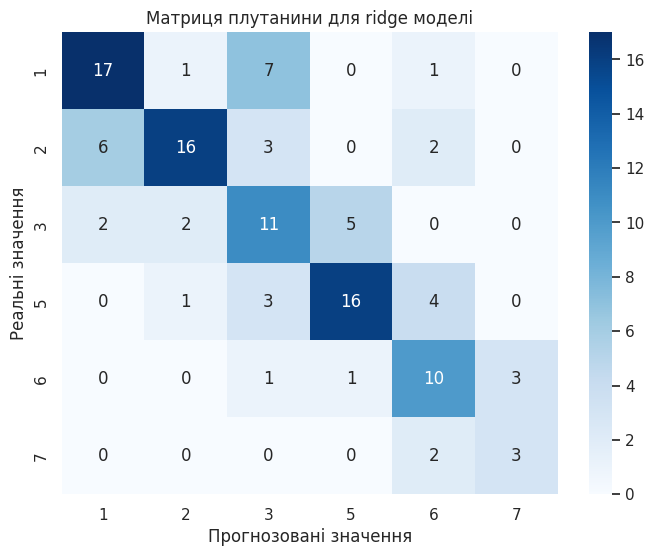


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.68      0.65      0.67        26
           2       0.80      0.59      0.68        27
           3       0.44      0.55      0.49        20
           5       0.73      0.67      0.70        24
           6       0.53      0.67      0.59        15
           7       0.50      0.60      0.55         5

    accuracy                           0.62       117
   macro avg       0.61      0.62      0.61       117
weighted avg       0.65      0.62      0.63       117


Точність моделі (Accuracy): 0.6239316239316239


In [415]:
ridge = RidgeClassifier()
ridge.fit(X_train_scaled_SS, y_train)
y_pred_ridge = ridge.predict(X_test_scaled_SS)
precision_ridge_SS = precision_score(y_test, y_pred_ridge, average='weighted', zero_division=0)
print(f"RidgeClassifier Precision: {precision_ridge_SS:.3f}")


conf_matrix = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для ridge моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_ridge, zero_division=1))
accuracy_ridge_SS = accuracy_score(y_test, y_pred_ridge)
print(f"\nТочність моделі (Accuracy): {accuracy_ridge_SS}")

KNN

KNN (k=5) Precision: 0.669


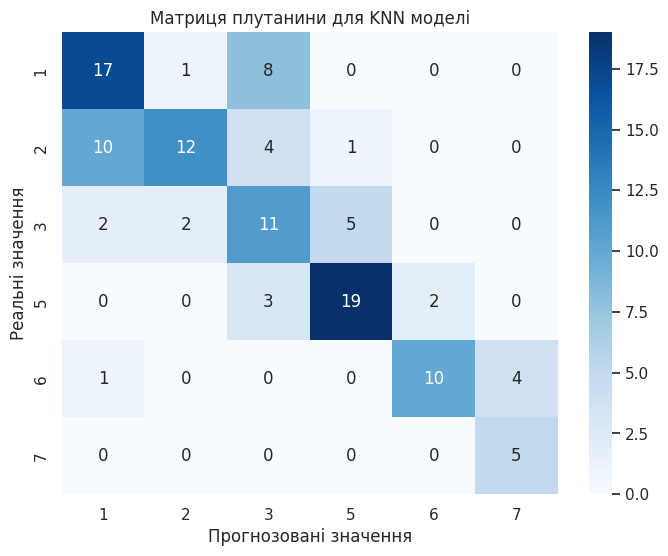


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.57      0.65      0.61        26
           2       0.80      0.44      0.57        27
           3       0.42      0.55      0.48        20
           5       0.76      0.79      0.78        24
           6       0.83      0.67      0.74        15
           7       0.56      1.00      0.71         5

    accuracy                           0.63       117
   macro avg       0.66      0.68      0.65       117
weighted avg       0.67      0.63      0.63       117


Точність моделі (Accuracy): 0.6324786324786325


In [416]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled_SS, y_train)
y_pred_knn = knn.predict(X_test_scaled_SS)
precision_knn_SS = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
print(f"KNN (k=5) Precision: {precision_knn_SS:.3f}")


conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для KNN моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_knn, zero_division=0))
accuracy_knn_SS = accuracy_score(y_test, y_pred_knn)
print(f"\nТочність моделі (Accuracy): {accuracy_knn_SS}")

Logistic Regression

Logistic Regression Precision: 0.681


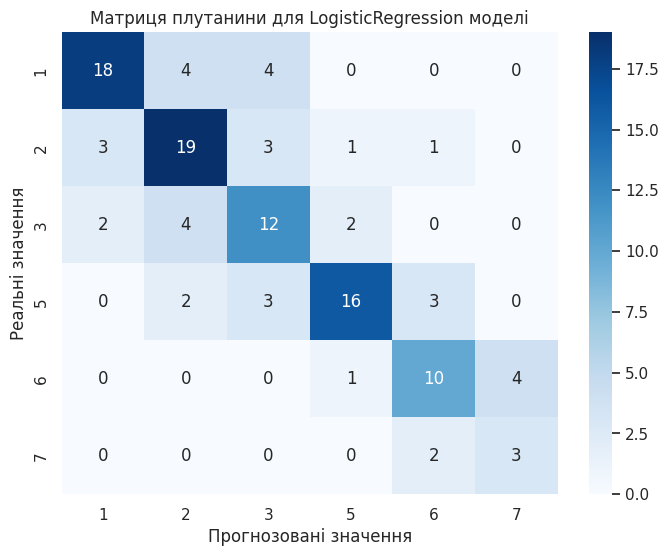


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.78      0.69      0.73        26
           2       0.66      0.70      0.68        27
           3       0.55      0.60      0.57        20
           5       0.80      0.67      0.73        24
           6       0.62      0.67      0.65        15
           7       0.43      0.60      0.50         5

    accuracy                           0.67       117
   macro avg       0.64      0.65      0.64       117
weighted avg       0.68      0.67      0.67       117


Точність моделі (Accuracy): 0.6666666666666666


In [417]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_scaled_SS, y_train)
y_pred_logreg = logreg.predict(X_test_scaled_SS)
precision_logreg_SS = precision_score(y_test, y_pred_logreg, average='weighted', zero_division=0)
print(f"Logistic Regression Precision: {precision_logreg_SS:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для LogisticRegression моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))
accuracy_logreg_SS = accuracy_score(y_test, y_pred_logreg)
print(f"\nТочність моделі (Accuracy): {accuracy_logreg_SS}")

якщо трозібратися по таргетаммодель спрацювала краще за єталон але із за того що SVMSMOTEне вирівняв кількості доданіх рядкі в силу своєї роботи там де було додано не достатньо рядків ми маємо провал

SMOTE

In [449]:
X_S = feature_matrix_SMOTE_cleaned.drop(columns=["Type"]).values
y_S = feature_matrix_SMOTE_cleaned["Type"].values
X_train, X_test, y_train, y_test = train_test_split(X_S, y_S, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled_S = scaler.fit_transform(X_train)
X_test_scaled_S = scaler.transform(X_test)

RidgeClassifier

RidgeClassifier Precision: 0.845


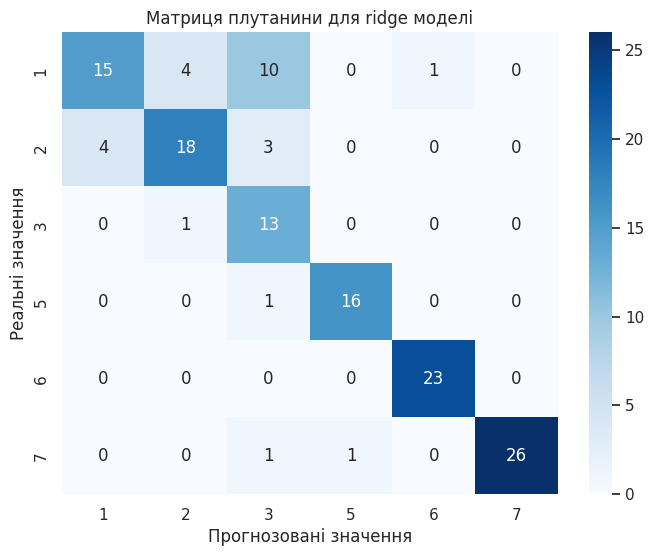


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.79      0.50      0.61        30
           2       0.78      0.72      0.75        25
           3       0.46      0.93      0.62        14
           5       0.94      0.94      0.94        17
           6       0.96      1.00      0.98        23
           7       1.00      0.93      0.96        28

    accuracy                           0.81       137
   macro avg       0.82      0.84      0.81       137
weighted avg       0.85      0.81      0.81       137


Точність моделі (Accuracy): 0.8102189781021898


In [450]:
ridge = RidgeClassifier()
ridge.fit(X_train_scaled_S, y_train)
y_pred_ridge = ridge.predict(X_test_scaled_S)
precision_ridge_S = precision_score(y_test, y_pred_ridge, average='weighted', zero_division=0)
print(f"RidgeClassifier Precision: {precision_ridge_S:.3f}")


conf_matrix = confusion_matrix(y_test, y_pred_ridge)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для ridge моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_ridge, zero_division=1))
accuracy_ridge_S = accuracy_score(y_test, y_pred_ridge)
print(f"\nТочність моделі (Accuracy): {accuracy_ridge_S}")

KNN

KNN (k=5) Precision: 0.829


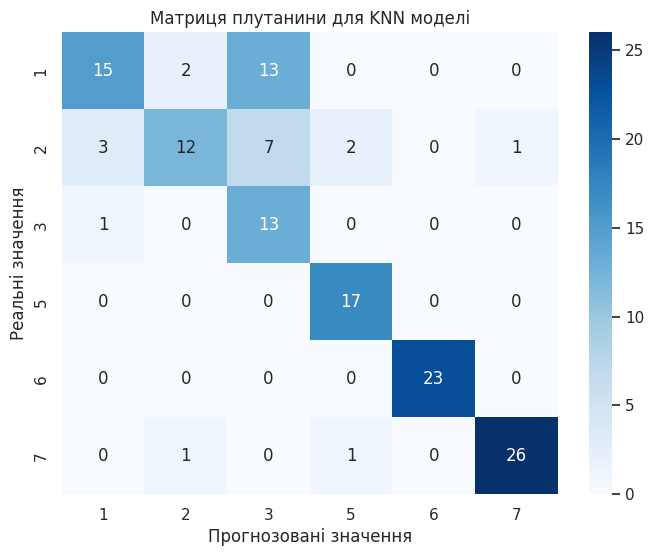


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.79      0.50      0.61        30
           2       0.80      0.48      0.60        25
           3       0.39      0.93      0.55        14
           5       0.85      1.00      0.92        17
           6       1.00      1.00      1.00        23
           7       0.96      0.93      0.95        28

    accuracy                           0.77       137
   macro avg       0.80      0.81      0.77       137
weighted avg       0.83      0.77      0.78       137


Точність моделі (Accuracy): 0.7737226277372263


In [451]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled_S, y_train)
y_pred_knn = knn.predict(X_test_scaled_S)
precision_knn_S = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
print(f"KNN (k=5) Precision: {precision_knn_S:.3f}")


conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для KNN моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_knn, zero_division=0))
accuracy_knn_S = accuracy_score(y_test, y_pred_knn)
print(f"\nТочність моделі (Accuracy): {accuracy_knn_S}")

Logistic Regression

Logistic Regression Precision: 0.852


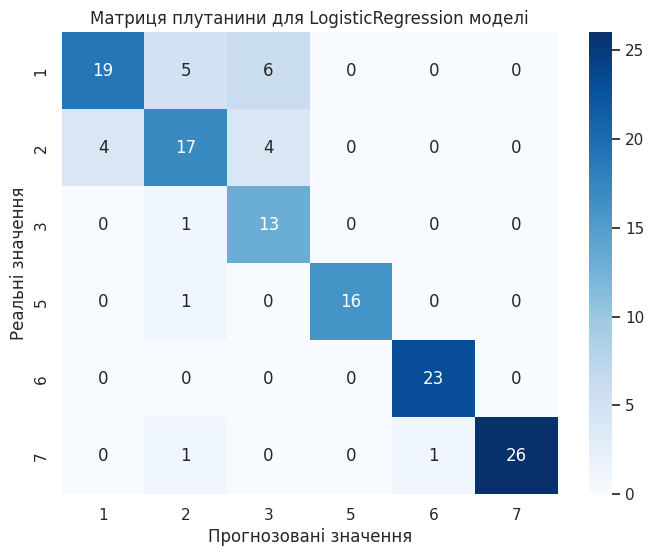


Звіт про класифікацію для sex_encoded:
              precision    recall  f1-score   support

           1       0.83      0.63      0.72        30
           2       0.68      0.68      0.68        25
           3       0.57      0.93      0.70        14
           5       1.00      0.94      0.97        17
           6       0.96      1.00      0.98        23
           7       1.00      0.93      0.96        28

    accuracy                           0.83       137
   macro avg       0.84      0.85      0.84       137
weighted avg       0.85      0.83      0.83       137


Точність моделі (Accuracy): 0.8321167883211679


In [452]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train_scaled_S, y_train)
y_pred_logreg = logreg.predict(X_test_scaled_S)
precision_logreg_S = precision_score(y_test, y_pred_logreg, average='weighted', zero_division=0)
print(f"Logistic Regression Precision: {precision_logreg_S:.3f}")

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Прогнозовані значення')
plt.ylabel('Реальні значення')
plt.title('Матриця плутанини для LogisticRegression моделі')
plt.show()

print("\nЗвіт про класифікацію для sex_encoded:")
print(classification_report(y_test, y_pred_logreg, zero_division=0))
accuracy_logreg_S = accuracy_score(y_test, y_pred_logreg)
print(f"\nТочність моделі (Accuracy): {accuracy_logreg_S}")

маємо добрий результат як наші створені фічі так додані рядки до макс значення дуже сильно полібшели якість моделей найкраще впоралась модель LogisticRegression роботу наших фічей можемо побачити по перших 2 таргетах яких було найбільше в єталонному датасеті

In [453]:
data_a_v = [accuracy_knn, accuracy_logreg, accuracy_ridge,
            accuracy_knn_S, accuracy_logreg_S, accuracy_ridge_S,
            accuracy_knn_SS, accuracy_logreg_SS, accuracy_ridge_SS]
data_p_v = [precision_knn, precision_logreg, precision_ridge,
          precision_knn_S, precision_logreg_S, precision_ridge_S,
          precision_knn_SS, precision_logreg_SS, precision_ridge_SS]

data_a_k = ['accuracy_knn', 'accuracy_logreg', 'accuracy_ridge',
            'accuracy_knn_S', 'accuracy_logreg_S', 'accuracy_ridge_S',
            'accuracy_knn_SS', 'accuracy_logreg_SS', 'accuracy_ridge_SS']
data_p_k = ['precision_knn', 'precision_logreg', 'precision_ridge',
          'precision_knn_S', 'precision_logreg_S', 'precision_ridge_S',
          'precision_knn_SS', 'precision_logreg_SS', 'precision_ridge_SS']

df_accuracy = pd.DataFrame({
    "Назва змінної": data_a_k,
    "Значення": data_a_v
})

df_precision = pd.DataFrame({
    "Назва змінної": data_p_k,
    "Значення": data_p_v
})


In [435]:
fig_accuracy = px.bar(df_accuracy, x="Значення", y="Назва змінної",
                      title="Accuracy моделей", labels={"Значення": "Accuracy", "Назва змінної": ""})
fig_accuracy.update_traces(texttemplate='%{x:.3f}', textposition='outside')

fig_precision = px.bar(df_precision, x="Значення", y="Назва змінної",
                       title="Precision моделей", labels={"Значення": "Precision", "Назва змінної": ""})
fig_precision.update_traces(texttemplate='%{x:.3f}', textposition='outside')

fig_accuracy.show()
fig_precision.show()

ці зведені графіки підтверджують наці попердні висновки також бачемо що для нашого датасету на всіх єтапах найкращий результат показувала модель лінійної регресії